<a href="https://colab.research.google.com/github/jjonhwa/DeepLearning.AI-TensorFlow/blob/main/Chapter_3_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.1 Mnist
Mnist : 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70000개의 작은 숫자 이미지를 모은 Dataset이다.  

Date의 형태가 어떻게 생겼는지 그리고 type 및 shape변환을 해주도록 하자.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape) # 총 7만개의 이미지 + 784개의 특성(28*28 이미지 픽셀)
print(y.shape) # 총 7만개의 이미지.

(70000, 784)
(70000,)


In [3]:
len(X[0])

784

784
(784,)


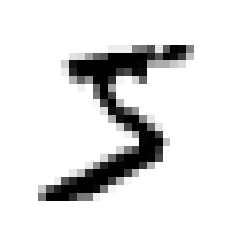

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

some_digit = X[0]
print(len(some_digit))
print(some_digit.shape)
some_digit_image = some_digit.reshape(28, 28) # 28*28 모양으로 바꿔준다.

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('Off')
plt.show()

In [5]:
y[0]

'5'

In [6]:
import numpy as np

y = y.astype(np.uint8) # y를 정수형으로 변환

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# Training Set을 6만개로 Test Set을 10000개로 해서 Train Test Split를 한다.

# 3.2 이진 분류기 훈련
이진 분류 : 예를 들어, 1인지 아닌지를 확인하는 Classification  

빠르게 '5-감지기'를 만들어 5인지 아닌지로 구분해서 데이터를 나누도록 하자.

In [8]:
y_train_5 = (y_train == 5) # Boolean Indexing으로 각 y값이 5이면 T 아니면 False를 반환한다. 
y_test_5 = (y_test == 5)
print(y_train_5[:10])

[ True False False False False False False False False False]


In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

* SGD(Stochastic Gradient Descent) : Training을 무작위로한다(반복수마다 training data를 섞어준다.), 확률적 경사 하강법이라는 뜻으로 이 분류기는 **매우 큰 데이터셋을 처리**를 잘하는 장점이 있고 **한 번에 하나씩 training sample을 독립적으로 처리**한다는 특징이 있다.


In [10]:
sgd_clf.predict([some_digit]) # 숫자 5의 이미지를 확인하여 제대로 예측하는지 확인해보자.

array([ True])

# 3.3 성능 측정

이 장에서는 성능을 확인할 수 있는 지표에 대해 알아보도록 하자.

## 3.3.1 교차 검증을 사용한 정확도 측정
다음은 교차 검증을 직접구현 한 코드이다.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)
# StratifiedFold : 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행한다.

for train_index, test_index in skfolds.split(X_train, y_train_5) :
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_folds = X_train[test_index]
  y_test_folds = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_folds)
  n_correct = sum(y_pred == y_test_folds)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


가끔 위처럼 sklearn이 제공하는 것보다 교차 검증 과정을 더 많이 제어해야 할 필요성이 있을 경우 위처럼 직접 구현하면된다!!  

?? 뭐를 더 많이 제어할 수 있는가?

이번에는 cross_val_score()를 이용하여 SGDClassifier 모델을 평가해보도록 하자.

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')
# 'cv = 3' : kfold cross valdiation 에서 3개의 폴드로 나누는 것을 의마한다.

array([0.95035, 0.96035, 0.9604 ])

KFold로 모델을 평가했을 때 꽤나 정확한 정확도를 얻었다. 하지만 여기서 binary classification(5인가 아닌가)를 했으므로 Dummy classification을 이용해서 한 번 더 확인해주도록 한다!(Binary의 경우 분류 기준을 '5이다'라고만 예측해도 Data가 inbalanced일 경우 정확도가 높을 수 있다.)

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator) :
  def fit(self, X, y = None) :
    return self
  
  def predict(self, X) :
    return np.zeros((len(X), 1), dtype = bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

즉! 위의 결과처럼, 모든 데이터를 5가 아니라고 예측했을 때의 정확도가 90%임을 알 수 있다.  

위의 예시처럼, 우리가 정확도를 측정 지표로 선호하지 않는 이유를 알 수 있다.  
앞서 말했듯이, Inbalanced Dataset을 다룰 경우 위처럼, 정확도는 오류를 범할 수 있다.

## 3.3.2 오차행렬
* 오차 행렬 : A를 B라고 분류한 횟수를 세는 것이다!
오차 행렬을 만들려면 실제 타깃과 비교할 수 있는 예측값을 만들어야 한다! 여기서는 **Test로 예측을 만드는 것이 아니라 `cross_val_predict`를 사용해 예측값을 만든다**.

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

`cross_val_predict()`는 `cross_val_score()`와 달리 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다. 그래서 이 예측된 값을 실제 타깃과 비교하여 confusion matrix(오차 행렬)을 반환하도록한다.

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Confulsion Matrix에서 행은 실제 클래스를 열은 예측 클래스를 나타낸다.  

정확도뿐만 아니라 살펴볼만한 지표들로는 **정밀도**와 **재현율**이 있다.  
보통 이 두 개(정밀도, 재현율)의 지표를 함께 사용하는 것이 일반적이다.

* 정밀도 : 맞다라고 판단한 것들 중에 제대로 맞은 것들의 비율
* 재현율 : 실제로 맞는 것들 중에 제대로 예측한 것들의 비율

## 3.3.3 정밀도 와 재현율
정밀도와 재현율을 포함한 분류기의 지표를 계산하는 여러 함수와 F1지표에 대해서 알아보자.

In [17]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


정밀도와 재현율을 하나의 지표로 표시하기 위해서 자주 사용하는 측정 지표가 **F1 Score**이다.  

* F1 Score : 정밀도와 재현율의 조화평균으로 이루어져 있다.(2 / (1/정확도 + 1/재현율))

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷할 떄 F1 Score점수가 높다. 하지만, 이것이 항상 바람직한 것만은 아니다. 상황에 따라 정밀도가 더 중요할 수도, 재현율이 더 중요할 수도 있으니 상황에 맞춰 사용하도록 하자.  

더불어, 정밀도와 재현율은 불행히도 동시에 높게 얻을 수없는 트레이드오프의 관계이니 이것도 참고하고 있자.

## 3.3.4 정밀도/재현율 트레이드 오프

SGDClassifier의 경우 Decision Function을 바탕으로 각 샘플의 점수를 계산한다. 이 때 그 점수가 임곗값보다 크면 양성, 아니면 음성으로 할당한다.  

이 때 임곗값이 커질수록 혹은 작아질수록 정밀도가 높아지면 재현율은 낮아지는 것을 확인할 수 있다.(그림이 없으므로 이 정도로 설명하고 넘어가도록 하겠다.)  

사이킷런에서 직접 임겠값을 정할 순 없지만 다음은 임곗값이 높아졌을 때를 가정한 예시이니 간단히 확인하고 넘어가도록 하자.

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
# decision function은 labeling이 되는 것이 아니라 점수로 반환된다.
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred) # 임곗값을 0으로 줬을 때 결과가 어떻게 나오는지 확인한다.

[2164.22030239]
[ True]


In [20]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # 임곗값을 8000으로 줬을 때 결과가 어떻게 나오는지 확인한다.

array([False])

그렇다면 적절한 임곗값을 어떻게 정할까!?  

`cross_val_predict`를 사용하여 Training Set의 모든 샘플의 점수를 구해야한다.


In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,
                             cv = 3, method = 'decision_function')

`precision_recall_curve()`를 사용하여 모든 임곗값에 대한 정밀도와 재현율을 계산할 수 있다.



In [22]:
from sklearn.metrics import precision_recall_curve

precision, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

다음은 한글폰트를 사용하기위한 코드이므로 필요없다면 Skip하도록 하자.


In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44247 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/bac

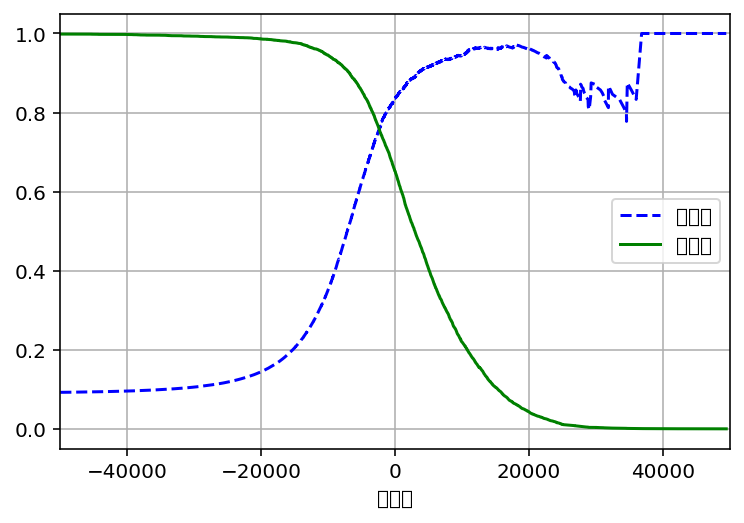

In [24]:
def plot_precision_recall_vs_threshold(precision, recalls, thresholds) :
  plt.plot(thresholds, precision[:-1], 'b--', label = '정밀도')
  plt.plot(thresholds, recalls[:-1], 'g-', label = '재현율')
  plt.xlabel('임곗값')
  plt.xlim(-50000, 50000)
  plt.legend()
  plt.grid(True)
  plt.show()

plot_precision_recall_vs_threshold(precision, recalls, thresholds)

위의 그래프를 보면 정밀도 곡선이 재현율보다 울퉁부툴할 수 있다.  

이는 임곗값이 올라도 정밀도가 가끔 낮아질 수 있다는 특징이 있기 떄문이다. 이에 더불어 재현율은 임곗값이 올라가면 무조건 줄어들 수밖에 없기 때문에 부드러운 곡선이 된다.

위 그래프로부터 정밀도와 재현율의 트레이드 오프 관계를 시각적으로 알 수 있으며 어느 정도로 타협하여 설정할 지는 각 프로젝트에 따라 다르므로 각 상황에 맞게 선택하면 된다.  

짧은 예로, 정확도가 90%는 넘으면서 가장 좋은 지표를 찾는 문제를 간략히 해결해보도록 하자.



In [25]:
threshold_90_precision = thresholds[np.argmax(precision >= 0.90)]
threshold_90_precision
# np.argmax : 최대값의 첫 번째 인덱스 반환

3370.0194991439557

In [26]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


위처럼 정밀도는 최소조건으로 90%를 넘기면서 재현율을 최대로 할 수 있도록 해주도록 한다.

## 3.3.5 ROC 곡선
* ROC(Receiver Operating Characteristic)
1. 이진 분류에서 많이 사용함.
2. 거짓 양성 비율(FPR)(맞다고 예측한 것들 중에서 아닌 것들의 비율)에 대한 진짜 양성 비율(TPR)(실제로 맞는 것들 중에서 맞다고 예측한 것들의 비율 - 재현율)이다.
3. ROC곡선을 그리기 전에 `roc_curve()`를 사용해서 여러 임곗값에서 TPR과 FPR을 계산한다.

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51667 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_

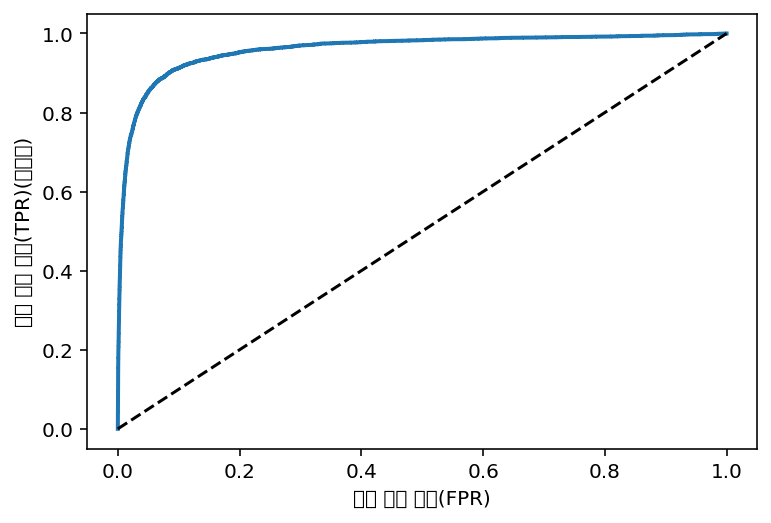

In [28]:
def plot_roc_curve(fpr, tpr, label = None) :
  plt.plot(fpr, tpr, linewidth = 2, label = label)
  plt.plot([0,1], [0, 1], 'k--')
  plt.xlabel('거짓 양성 비율(FPR)')
  plt.ylabel('진짜 양성 비율(TPR)(재현율)')

plot_roc_curve(fpr, tpr)
plt.show()

여기서 역시 TPR과 FPR은 트레이드 오프 관계가 있음을 알 수 있다.  

가운데 있는 점선은 완전한 랜덤 분류기일 때 ROC곡선을 의미한다. 가운데 점선으로부터 최대한 멀리 떨어져 있어서 좋은 분류기이다.

* AUC(Area Under the Curve) :
1. ROC의 아래 면적을 의미한다.
2. 완벽한 분류기는 ROC AUC가 1이다.
3. 완전한 분류기는 ROC AUC가 0.5이다.(위에서 가운데 점선)
4. `roc_auc_score`를 이용해 ROC AUC를 계산할 수 있다.

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

PR(정밀도/재현율) 곡선과 ROC 곡선 중에서 어떤 것을 써야할지 궁금할 때는 다음과 같은 기준으로 선택하도록 해보자.
1. 양성 클래스가 드물 떄 : PR곡선
2. 거짓 음성보다 거짓 양성이 더 중요할 때 : PR곡선
3. 그 밖 : ROC 곡선

마지막으로, RandomForestClassifier와 SGDClassifier의 ROC곡선과 ROC AUC 점수를 비교해보도록 하자.

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                    method = 'predict_proba')
# predict_proba는 앞서 설명한 decision_function()(label이 아닌 점수 반환)의 역활을 RandomForest에서 한다.
# 샘플이 행, 클래스가 열, 샘플이 주어진 클래서에 속할 확률을 담은 배열을 반환한다.

In [31]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용한다.
fpr_forest, tpr_forest, threholds_forest = roc_curve(y_train_5, y_scores_forest)

In [32]:
def plot_roc_curve(fpr, tpr, label = None) :
  plt.plot(fpr, tpr, linewidth = 2, label = label)
  plt.plot([0,1], [0, 1], 'k--')
  plt.xlabel('거짓 양성 비율(FPR)')
  plt.ylabel('진짜 양성 비율(TPR)(재현율)')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51667 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_

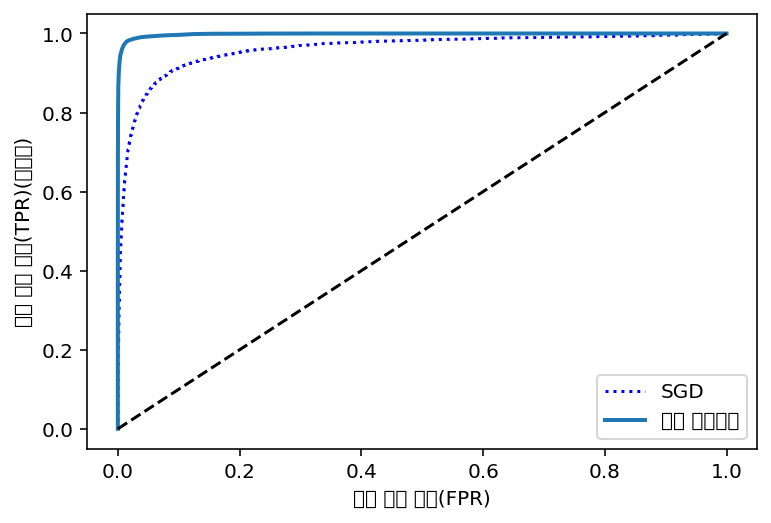

In [33]:
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plt.plot(fpr_forest, tpr_forest, linewidth = 2, label = '랜덤 포레스트')
plt.plot([0,1], [0, 1], 'k--')
plt.xlabel('거짓 양성 비율(FPR)')
plt.ylabel('진짜 양성 비율(TPR)(재현율)')
plt.legend()
plt.show()

ROC 곡선을 비교했을 때 랜덤 포레스트를 이용한 것이 왼쪽 위 모서리에 더 가까운 것으로 보아 성능이 훨씬 좋음을 알 수 있다. 당연히 ROC AUC 점수도 높다.

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# 3.4 다중 분류


* Multiclass classifier : 둘 이상의 클래스를 구별할 수 있다.

* OvR(One versus the Rest) : 여러 개의 이진 분류기를 훈련시켜 여러 클래스를 구별할 수 있다. 이미지의 경우 각 분류기의 점수 중 가장 높은 클래스로 선택하는 방법이다.
* OvO(One versus One) : 모든 조합(0과1, 0과2, 1과2 etc)을 비교해가면서 모든 클래스들을 각각 비교해서 가장 많이 양성으로 분류된 클래스를 선택한다. 주요 장점으로는 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것이다.

일부 알고리즘(ex, SVM)은 Training Set의 크기에 민감해서 작은 Training Set에서 많은 분류기를 훈련시키는 쪽이 빨라 OvO를 선호하나 대부분의 이진분류에서는 OvR을 선호한다.

다음의 코드를 사용하여 SVC를 테스트 해보도록 하자.

In [35]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])
# SVM 내부에서는 OvO전략으로 총 45개(0~9 classification 총 10개)의 이진 분류기를 훈련시키고
# 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택하는 것이다.

array([5], dtype=uint8)

In [36]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores
# decision_function()을 호출하면 샘플 당 10개의 점수를 반환한다.

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [37]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])
# Training을 할 때, classes_에 타깃 클래스 리스트를 정렬하여 저장한다.

5
[0 1 2 3 4 5 6 7 8 9]
5


사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 `OneVsOneClassifier`나 `OneVsRestClassifier`를 사용하면 된다. SVC기반으로 OvR을 사용하는 코드를 간단히 살펴보도록  하자.

In [39]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
print(ovr_clf.predict([some_digit]))
print(len(ovr_clf.estimators_))

[5]
10


SGDClassifier이나 RandomForestClassifier를 훈련시키는 것 역시 간단하며 위의 방법과 동일하다. SGD의 경우 직접 다중 클래스로 분류할 수 있기  때문에 별도로  OvR이나 OvO를 적용할 필요가 없다.  

SGDClassifier를 이용해서 각 클래스마다 어떤 값을 부여받았는지 확인해보도록 하자.

In [40]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

sgd_clf.decision_function([some_digit])
# decision_function()을 이용하면 클래스마다 점수가 어떻게 부여받았는지 확인할 수 있다.

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

`cross_val_score()`를 이용하여 분류기를 평가해보자. 그리고 Scaling을 해서 간단하게 정확도를 조금 더 올려보도록 하자.

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv =3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

# 3.5 에러 분석
모델의 성능을 향상시킬 수 있는 한가지 방법은 에러의 종류를 분석하는 것이다.

먼저, 오차 행렬을 살펴보기 위하여 `cross_val_predict()`를 활용하여 예측값을 만든 후  `confusion_matrix()`를 이용하여 호출하도록 하자.

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3,)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()
# matshow()함수를 이용하면 숫자출력을 이미지로 표현할 수 있다.
# 배열에서 가장 큰 값은 흰색으로 가장 작은 값은 검은색으로 정규화되어 그려진다.

그래프의 에러 부분에 초점을 맞추기 위해서 오차 행렬의 각 값을 대응디는 클래스의 이미지 개수로 나누어 에러 비율을 비교하도록 하자.(절대 개수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보이므로 앞서 말한 방식으로 진행하도록 한다.)

In [ ]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
# 주대각선만 0으로 채운 후 배열을 시각적으로 나타내보도록 한다.
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()
# 행은 실제 클래스를 열은 예측한 클래스를 나타낸다는 사실을 기억하자.

위에서 볼 수 있듯이 오차 행렬은 반드시 대칭인 것은 아니다,  

오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있다.  
위의 그림에서 볼 수 있듯이 8의 경우 잘못 분류되는 것을 줄이는 방안쪽으로 개선방향을 정할 수 있다. 또는 8을 더 잘 분류할 수 있도록 동심원을 세는 알고리즘 같은 것들을 특성으로 추가할 수도 있다.  

Error Analysis의 경우 분류기가 무슨 일을 하고 있고, 왜 잘못되었는지에 대한 통찰을 얻을 수 있다는 장점이 있지만 더 어렵고 시간이 오래걸린다는 단점이 있다.  

# 3.6 다중 레이블 분류
지금까지는 각 샘플이 하나의 클래스에만 할당되었다. 하지만 분류기가 샘플마다 여러개의 클래스를 출력해야 할 떄도 있다. 예를 들어, 얼굴을 인식하여 꼬리표를 출력해주는 것이 이러한 것이다.  
이런 것들을 **다중 레이블 분류(Multilabel Classification)**이라고 한다.  
다음의 간단한 예를 통해 이해를 돕도록 하자.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
# 두 개의 타깃 레이블이 담긴 y_multilabel을 만든다.

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit]) # some_digit은 5를 나타내므로 7보다 큰지 그리고 홀수인지를 나타내는 Output값이 나타날 것이다.

다중 레이블 분류기 역시 많은 방법들로 평가할 수 있고 이역시 프로젝트에 따라 다른 지표들을 사용하게 된다. 여기서는 간단하게 앞서 사용했던 F1 Score를 사용해보도록 하자.

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')
# f1_score에서 average를 macro로 준 것은 모든 레이블의 가중치를 동일하게 가정한 것이다.
# average = 'weighted'로 주면 가중치를 더 많이 줄 수도 있다.

# 3.7 다중 출력 분류
다중 출력 분류의 경우 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한 것이다.